This colab was created to prevent overfilling RAM with both CNN and Resnet models and the MLP models. Task 1 is repreated to import the data before continuting with tasks in section 3. Thank you. 

In [ ]:
# COMMON IMPORTS FOR THE WHOLE CODE
import pandas as pd
# replace numpy with cupy to drastically speed up performance
# means that you must be connected to a gpu to be able to run the notebook
#import cupy as np
import numpy as np
import seaborn as sns


# imports for models : ( source Colab Lecture Code )
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

# import the zscore function from scipi

# from scipy.stats import zscore
plt.style.use("dark_background") # for styling purposes

# Task 1 - Importing, Processing and Vectorizing the Data


---



## 1.1 - Importing the Data


---


We import the data and proccess it to give us the options of using the following training and test splits. We can first preprocess x to give us the following data. 

The training data are labelled before to indicate that they have not been split further into a validation dataset and a test dataset

- `x_train_raw_before, y_train_raw_before | x_test_raw, y_test_raw`: Imported directly from CFAR 10 to compute other dataset
- `x_train_before, x_test`: reshaped raw colour data
- `x_train_gray_before, x_test_gray`: reshaped raw grayscale data
- `x_train_normalized_before, x_test_normalized`: reshaped colour data normalized by pixel range
- `x_train_z_normalized_before, x_test_z_normalized`: reshaped colour data normalized with Z-score

We can then preprocess and onehot encode y so that the `50000 x 1` matrix becomes `500000 x 10`: 
- `y_train_before` - one hot encoded training data
- `y_test` - one hot encoded testing data


The data can be imported using tensorflow. The resulting variables are numpy arrays containing the data for training and testing. There are 50000 instances for training and 10000 instances for testing. The dataset consists of 32x32 images with RGB values, i.e. a pixel channel for red, green, and blue. Images are classified within 10 different classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

In [ ]:
import tensorflow as tf
(x_train_raw_before, y_train_raw_before), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()
cifar10_classes = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


print("Training data X: ", x_train_raw_before.shape)
print("Training data Y: ", y_train_raw_before.shape)
print("Test data X: ", x_test_raw.shape)
print("Test data Y: ", y_test_raw.shape)

170498071/170498071 [==============================] - 7s 0us/step
Training data X:  (50000, 32, 32, 3)
Training data Y:  (50000, 1)
Test data X:  (10000, 32, 32, 3)
Test data Y:  (10000, 1)


The data needs to be reshaped to fit into the input layer of the MLP.Lets visualize the original pictures from the test set. 

Training data X:  (50000, 3072)
Test data X:  (10000, 3072)


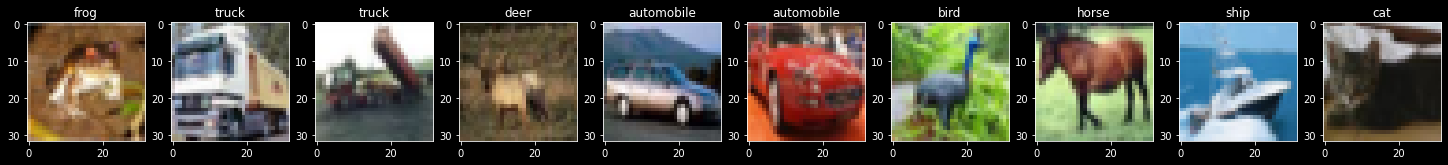

In [ ]:
# Reshaping the data
x_train_before = x_train_raw_before.reshape(x_train_raw_before.shape[0], x_train_raw_before.shape[1] * x_train_raw_before.shape[2] * x_train_raw_before.shape[3])
x_test = x_test_raw.reshape(x_test_raw.shape[0], x_test_raw.shape[1] * x_test_raw.shape[2] * x_test_raw.shape[3])

print("Training data X: ", x_train_before.shape)
print("Test data X: ", x_test.shape)

fig, axes = plt.subplots(1, 10, constrained_layout=True, figsize=(20, 20)) 
 
for i in range(10):
    # reshape the data to visualize it
    img = x_train_before[i].reshape(32,32,3)
    axes[i].imshow(img)
    axes[i].set_title(cifar10_classes[int(y_train_raw_before[i])])
plt.show()

## 1.2 - Processing and Vectorizing the Data


---



### 1.2.1 - Vectorizing X

Each image is composed of three superposed layer, one each for RGB values.
https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b 

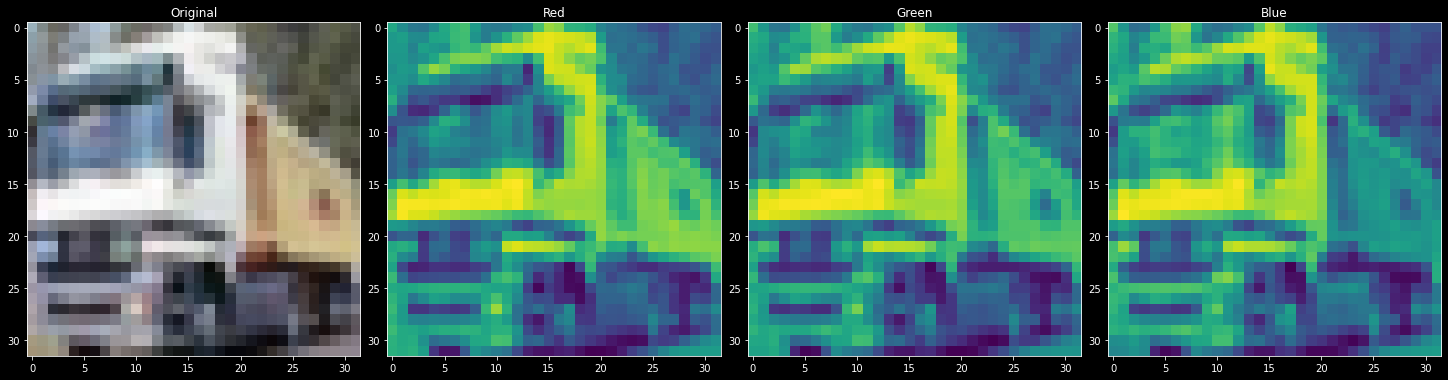

In [ ]:
fig, axes = plt.subplots(1, 4, constrained_layout=True, figsize=(20, 20)) 
img = x_train_before[1].reshape(32,32,3) # instance
axes[0].imshow(img)
axes[0].set_title("Original")
axes[1].imshow(img[:, : , 0]) # Red
axes[1].set_title("Red")
axes[2].imshow(img[:, : , 1]) # Green
axes[2].set_title("Green")
axes[3].imshow(img[:, : , 2]) # Blue
axes[3].set_title("Blue")
plt.show()

The images can also be viewed in grayscale.

X train gray shape:  (50000, 1024)
X test gray shape:  (10000, 1024)


<function matplotlib.pyplot.show(close=None, block=None)>

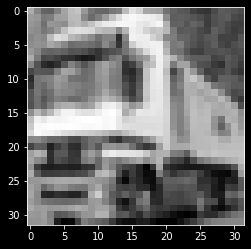

In [ ]:
from skimage.color import rgb2gray # from scikit-image
# converting the RGB images into grayscale, i.e. pixel values from 0-1
x_train_gray_raw = rgb2gray(x_train_raw_before)
x_test_gray_raw = rgb2gray(x_test_raw)

x_train_gray_before = x_train_gray_raw.reshape(x_train_gray_raw.shape[0], x_train_gray_raw.shape[1] * x_train_gray_raw.shape[2])
x_test_gray= x_test_gray_raw.reshape(x_test_gray_raw.shape[0], x_test_gray_raw.shape[1] * x_test_gray_raw.shape[2])

# print("X train gray shape raw: ", x_train_gray_raw.shape)
# print("X test gray shape raw: ", x_test_gray_raw.shape)
print("X train gray shape: ", x_train_gray_before.shape)
print("X test gray shape: ", x_test_gray.shape)

index = 1
plt.imshow(x_train_gray_before[index].reshape(32,32), cmap=plt.cm.gray)
plt.show

The images can be normalized using the range of values, i.e. dividing by 255.
https://www.kdnuggets.com/2018/10/preprocessing-deep-learning-covariance-matrix-image-whitening.html/3 

X train normalized shape:  (50000, 3072)
X test normalized shape:  (10000, 3072)
Max value is  1.0


Text(0.5, 1.0, 'Normalized (255)')

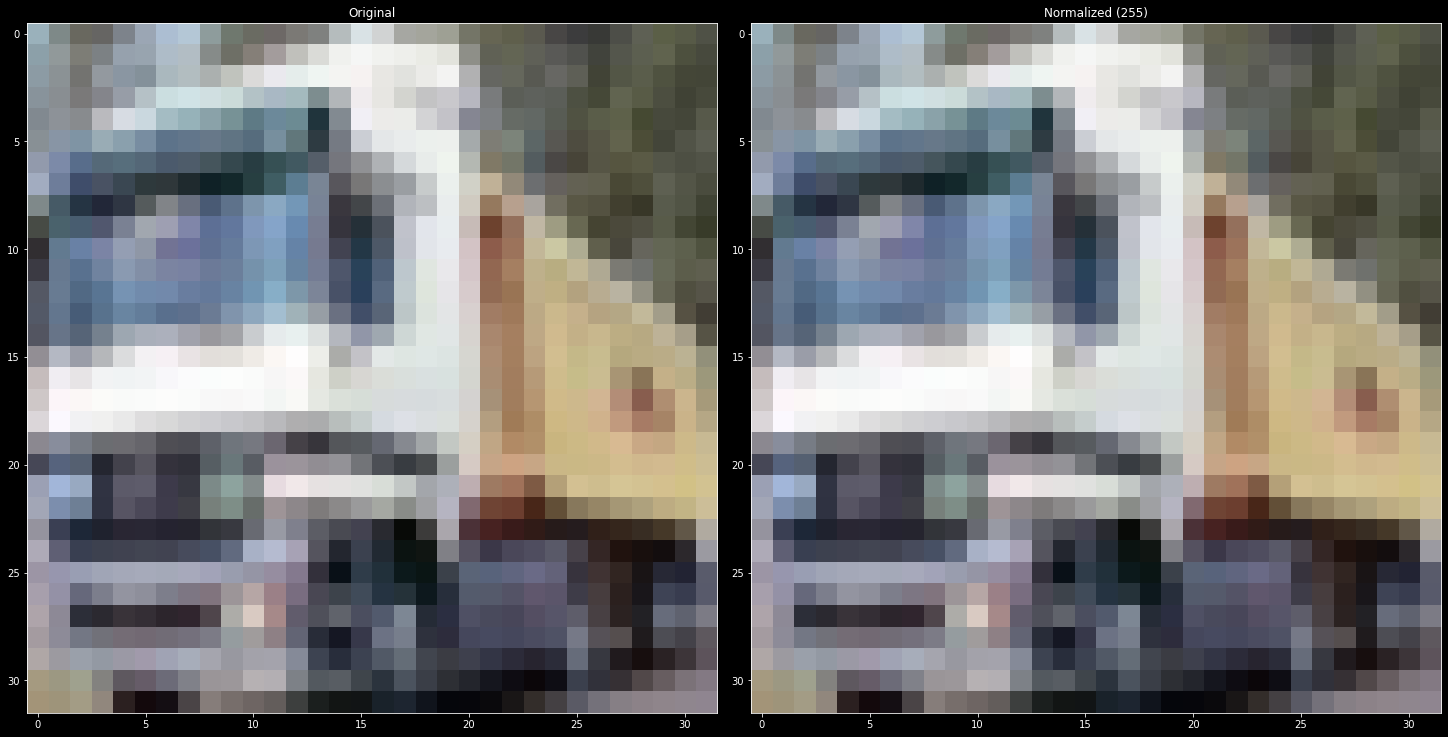

In [ ]:
# normalize based on normalized_data = (data - min(data)) / (max(data) - min(data))
# where min(data) = 0, the normalized data ranges for 0-1

x_train_normalized_before = x_train_before / 255.0 
x_test_normalized = x_test / 255.0 

print("X train normalized shape: ", x_train_normalized_before.shape)
print("X test normalized shape: ", x_test_normalized.shape)
print("Max value is ", x_train_normalized_before.max())

index = 1
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 20))
axes[0].imshow(x_train_before[index].reshape(32,32,3))
axes[0].set_title("Original")
axes[1].imshow(x_train_normalized_before[index].reshape(32,32,3))
axes[1].set_title("Normalized (255)")

The data can also be normalized by substracting the mean and dividing by the standard deviation. https://cs231n.github.io/neural-networks-2/

TO KEEP IN MIND: "Common pitfall. An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean) must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all splits (train/val/test)."

Text(0.5, 1.0, 'Normalized (dataset)')

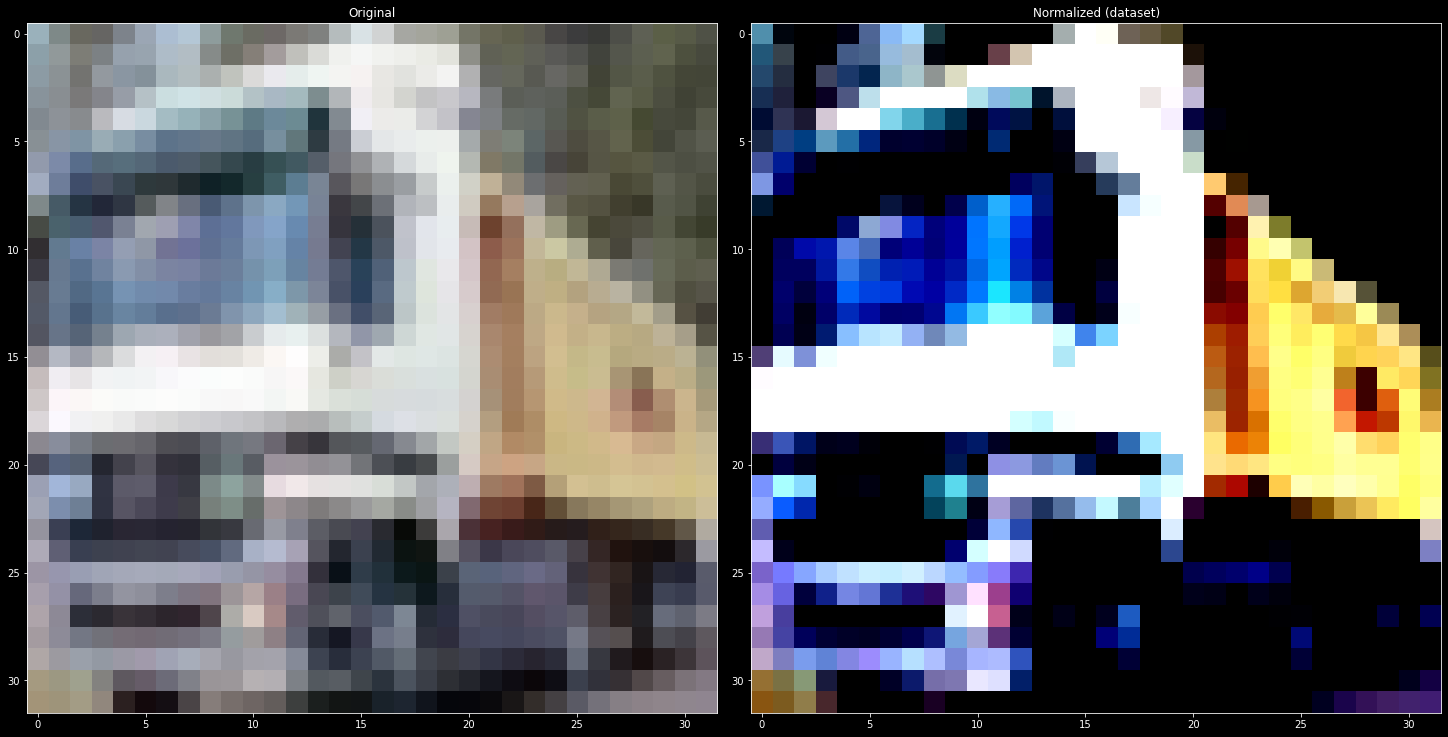

In [ ]:
# What should be the axis where we average?
x_train_z_normalized_before = (x_train_before - np.mean(x_train_before, axis=0)) / np.std(x_train_before, axis=0)
# for test data, use only training metrics
x_test_z_normalized = (x_test - np.mean(x_train_before, axis=0)) / np.std(x_train_before, axis=0)

# print("Mean shape: ", np.mean(x_train, axis=0).shape)
# print("STD shape: ", np.std(x_train, axis=0).shape)
# print("X train normalized (Z) shape: ", x_train_z_normalized.shape)
# print("X test normalized (Z) shape: ", x_test_z_normalized.shape)

# print("Mean is ", np.mean(x_train_z_normalized))
# print("STD is ", np.std(x_train_z_normalized))

index = 1
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 20))
axes[0].imshow(x_train_before[index].reshape(32,32,3))
axes[0].set_title("Original")
axes[1].imshow(x_train_z_normalized_before[index].reshape(32,32,3))
axes[1].set_title("Normalized (dataset)")

The data can also be whiten using PCA (Principal component analysis). https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371

In [ ]:
# from sklearn.decomposition import PCA
# #n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset
# x_train_pca = PCA(n_components=0.90)
# # pca_data = normSubMean_x_train[:200,:]
# pca_data = x_train_normalized[:200,...]
# x_train_pca.fit(pca_data) # fit function expects 2D array
# components = x_train_pca.transform(pca_data)
# projected = x_train_pca.inverse_transform(components)

# print(x_train_pca.components_.shape)
# print(components.shape)
# print(projected.shape)
# plt.imshow(projected[1])
# # fig, axes = plt.subplots(1,1,figsize=(9,9))
# # # for i, ax in enumerate(axes.flat):
# # axes[0].imshow(x_train_pca.components_[i].reshape(32,32,3))


### 1.2.2 - Vectorizing Y

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# one hot encode training and testing data
encoder = OneHotEncoder(categories ='auto',sparse =False)
encoder.fit(y_train_raw_before)
y_train_before = encoder.transform(y_train_raw_before)
encoder.fit(y_test_raw)
y_test = encoder.transform(y_test_raw)
y_train_before = np.array(y_train_before)
y_test = np.array(y_test)
# assert this worked
assert (y_train_before.shape == (50000,10))
assert (y_test.shape == (10000,10))


In [ ]:
# set the plot style background back to white
plt.style.use('default')


Convert the numpy arrays to cupy arrays for maximum GPU utilization

# Task 3 - CNNs and Pretrained Model



### 3.1.8 - EXTRA - MLPs with Tensor Flow

To better analyse the performance of the MLP built from scratch. The same architecture is replicated with Tensor flow librairies. A 1-layer and 2-layers MLPs are implemented and trained on the min-max normalized dataset.

#### 3.1.8.1 - 1 Hidden Layer MLP with TensorFlow

In [ ]:
from tensorflow.keras import layers, models, initializers
from keras.api._v2.keras import metrics

In [ ]:
# He Uniform weight initialization, to replicate the custom MLP architecure
initializer = tf.keras.initializers.HeUniform()

benchmark_1 = models.Sequential()
# Flatten input data, expects images to be 32x32x3
benchmark_1.add(layers.Flatten(input_shape=(32, 32, 3)))
# Single fully connected layer with weight initialization
benchmark_1.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
# Classification layer
benchmark_1.add(layers.Dense(10, activation='softmax'))

# get the model's architecture
benchmark_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plotAccuracies(history, modelName):
  plt.plot(history.history['accuracy'], label='training accuracy')
  plt.plot(history.history['val_accuracy'], label = 'test accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy for ' + modelName)
  plt.legend()

In [ ]:
# Reshape the data to fit
training_instances = x_train_z_normalized_before.reshape(x_train_z_normalized_before.shape[0], 32, 32, 3)
testing_instances = x_test_z_normalized.reshape(x_test_z_normalized.shape[0], 32, 32, 3)

In [ ]:
epochs = 24

benchmark_1.compile(optimizer='adam',
                  loss='categorical_crossentropy', # for one-hot encoded classes
                  metrics=['accuracy'])

# batch_size of 32 by default, 
history = benchmark_1.fit(training_instances, y_train_before, epochs=epochs, 
                        validation_data=(testing_instances, y_test),
                        # progress bar
                        verbose=1)



Epoch 1/24
1563/1563 [==============================] - 11s 4ms/step - loss: 2.1075 - accuracy: 0.3869 - val_loss: 1.6213 - val_accuracy: 0.4377
Epoch 2/24
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5261 - accuracy: 0.4702 - val_loss: 1.5693 - val_accuracy: 0.4551
Epoch 3/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4752 - accuracy: 0.4915 - val_loss: 1.6293 - val_accuracy: 0.4487
Epoch 4/24
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4325 - accuracy: 0.5088 - val_loss: 1.5851 - val_accuracy: 0.4622
Epoch 5/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3939 - accuracy: 0.5232 - val_loss: 1.5758 - val_accuracy: 0.4791
Epoch 6/24
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3458 - accuracy: 0.5419 - val_loss: 1.5330 - val_accuracy: 0.4874
Epoch 7/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3008 - accuracy: 0.5548 - val_loss: 1.5499 - val_accuracy

313/313 - 1s - loss: 2.0843 - accuracy: 0.4879 - 622ms/epoch - 2ms/step
Test loss is  2.0843493938446045
Test accuracy is  0.4878999888896942


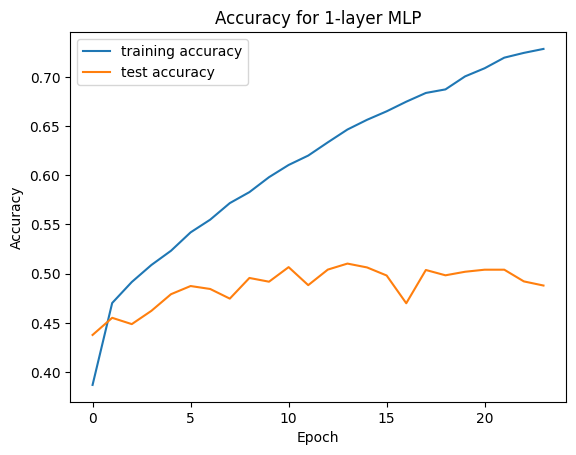

In [ ]:
plotAccuracies(history, '1-layer MLP')

test_loss, test_acc = benchmark_1.evaluate(testing_instances,  y_test, verbose=2)
print("Test loss is ", test_loss)
print("Test accuracy is ", test_acc)

#### 3.1.8.2 - 2 Hidden Layers MLP with TensorFlow

In [ ]:
benchmark_2 = models.Sequential()
# Flatten input data, expects images to be 32x32x3
benchmark_2.add(layers.Flatten(input_shape=(32, 32, 3)))
# 2 fully connected layers with weight initialization
benchmark_2.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
benchmark_2.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
# Classification layer
benchmark_2.add(layers.Dense(10, activation='softmax'))

# get the model's architecture
benchmark_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               786688    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
benchmark_2.compile(optimizer='adam',
                  loss='categorical_crossentropy', # for one-hot encoded classes
                  metrics=['accuracy'])

# batch_size of 32 by default, 
history = benchmark_2.fit(training_instances, y_train_before, epochs=epochs, 
                        validation_data=(testing_instances, y_test),
                        # progress bar
                        verbose=1)



Epoch 1/24
1563/1563 [==============================] - 7s 4ms/step - loss: 1.7886 - accuracy: 0.3900 - val_loss: 1.5823 - val_accuracy: 0.4447
Epoch 2/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5155 - accuracy: 0.4649 - val_loss: 1.5295 - val_accuracy: 0.4547
Epoch 3/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4318 - accuracy: 0.4933 - val_loss: 1.5230 - val_accuracy: 0.4567
Epoch 4/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3685 - accuracy: 0.5157 - val_loss: 1.4901 - val_accuracy: 0.4745
Epoch 5/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3149 - accuracy: 0.5353 - val_loss: 1.4599 - val_accuracy: 0.4970
Epoch 6/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2585 - accuracy: 0.5567 - val_loss: 1.4405 - val_accuracy: 0.5025
Epoch 7/24
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2123 - accuracy: 0.5699 - val_loss: 1.4348 - val_accuracy:

313/313 - 1s - loss: 1.9357 - accuracy: 0.5107 - 629ms/epoch - 2ms/step
Test loss is  1.9356787204742432
Test accuracy is  0.510699987411499


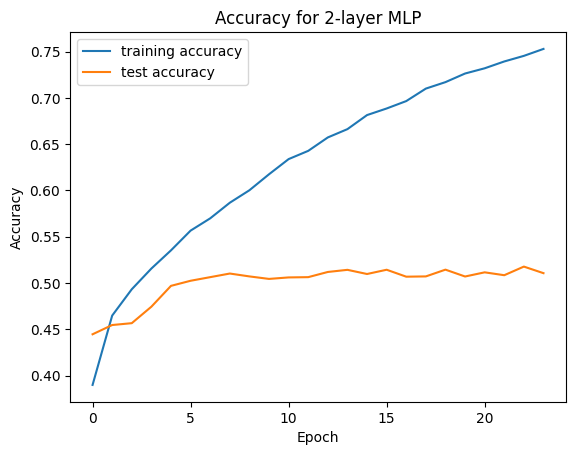

In [ ]:
plotAccuracies(history, '2-layer MLP')

test_loss, test_acc = benchmark_2.evaluate(testing_instances,  y_test, verbose=2)
print("Test loss is ", test_loss)
print("Test accuracy is ", test_acc)

## 3.5 - Convolutional Neural Networks

A convolutional neural network is trained on the same dataset. The CNN has 2 convolutional and 2 fully connected layers of 256 units. The activations are ReLU for each hidden layer.

### 3.5.1 - CNN Model Architecture

Simple CNN with no MaxPooling

In [ ]:
cnn_no_pooling = models.Sequential()

cnn_no_pooling.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn_no_pooling.add(layers.Conv2D(32, (3, 3), activation='relu'))
# Convert 2D into 1D for fully connected layers
cnn_no_pooling.add(layers.Flatten())
# Fully connected layers: number of units, activation function
cnn_no_pooling.add(layers.Dense(256, activation='relu'))
cnn_no_pooling.add(layers.Dense(256, activation='relu'))
# Last layer
cnn_no_pooling.add(layers.Dense(10, activation='softmax'))

cnn_no_pooling.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 6,501,290
Trainable params: 6,501,290
No

In [ ]:
epochs = 10

cnn_no_pooling.compile(optimizer='adam',
                  loss='categorical_crossentropy', # for one-hot encoded classes
                  metrics=['accuracy'])

# use data from 3.1.8
history = cnn_no_pooling.fit(training_instances, y_train_before, epochs=epochs, 
                        validation_data=(testing_instances, y_test),
                        # progress bar
                        verbose=1)



Epoch 1/10
1563/1563 [==============================] - 21s 7ms/step - loss: 1.2807 - accuracy: 0.5435 - val_loss: 1.0560 - val_accuracy: 0.6207
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8300 - accuracy: 0.7095 - val_loss: 1.0075 - val_accuracy: 0.6538
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4880 - accuracy: 0.8299 - val_loss: 1.1396 - val_accuracy: 0.6556
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2327 - accuracy: 0.9211 - val_loss: 1.5072 - val_accuracy: 0.6387
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1385 - accuracy: 0.9529 - val_loss: 1.8811 - val_accuracy: 0.6305
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1077 - accuracy: 0.9646 - val_loss: 2.2777 - val_accuracy: 0.6324
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0863 - accuracy: 0.9723 - val_loss: 2.2479 - val_accur

313/313 - 1s - loss: 2.7739 - accuracy: 0.6188 - 851ms/epoch - 3ms/step
Test loss is  2.7738828659057617
Test accuracy is  0.6187999844551086


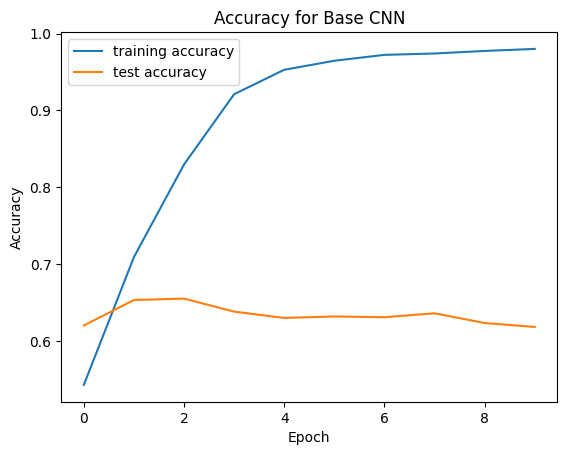

In [ ]:
plotAccuracies(history, 'Base CNN')

test_loss, test_acc = cnn_no_pooling.evaluate(testing_instances,  y_test, verbose=2)
print("Test loss is ", test_loss)
print("Test accuracy is ", test_acc)

The next CNN follows the architecture from a TensorFlow tutorial. The combination of convolutional layers and max pooling layers model is used as a base and two fully connected layers of 256 units are added on top. https://www.tensorflow.org/tutorials/images/cnn 

In [ ]:
cnn_base = models.Sequential()

# Args: number of filters (feature maps), filter size, activation function, shape of input layer (only necessary for first layer)
cnn_base.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# Downsample output of convolutional layers => less computational complexity
# More robust to translation => better generalization
cnn_base.add(layers.MaxPooling2D((2, 2)))
cnn_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_base.add(layers.MaxPooling2D((2, 2)))
# Convert 2D into 1D for fully connected layers
cnn_base.add(layers.Flatten())
# Fully connected layers: number of units, activation function
cnn_base.add(layers.Dense(256, activation='relu'))
cnn_base.add(layers.Dense(256, activation='relu'))
# Classification layer
cnn_base.add(layers.Dense(10, activation='softmax'))

cnn_base.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_5 (Dense)             (None, 256)              

In [ ]:
# to prevent crashing the session
batch_size = 32

cnn_base.compile(optimizer='adam',
                  loss='categorical_crossentropy', # for one-hot encoded classes
                  metrics=['accuracy'])

# use data from 3.1.8
history = cnn_base.fit(training_instances, y_train_before, batch_size=batch_size, epochs=epochs, 
                        validation_data=(testing_instances, y_test),
                        # progress bar
                        verbose=1)



Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 1.2866 - accuracy: 0.5396 - val_loss: 1.0085 - val_accuracy: 0.6470
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8969 - accuracy: 0.6866 - val_loss: 0.9402 - val_accuracy: 0.6763
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7076 - accuracy: 0.7530 - val_loss: 0.8657 - val_accuracy: 0.7079
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5575 - accuracy: 0.8051 - val_loss: 0.8707 - val_accuracy: 0.7108
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4312 - accuracy: 0.8491 - val_loss: 0.9008 - val_accuracy: 0.7191
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3243 - accuracy: 0.8856 - val_loss: 1.0562 - val_accuracy: 0.7152
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2403 - accuracy: 0.9153 - val_loss: 1.1857 - val_accuracy

313/313 - 1s - loss: 1.5923 - accuracy: 0.7066 - 796ms/epoch - 3ms/step
Test loss is  1.5922635793685913
Test accuracy is  0.70660001039505


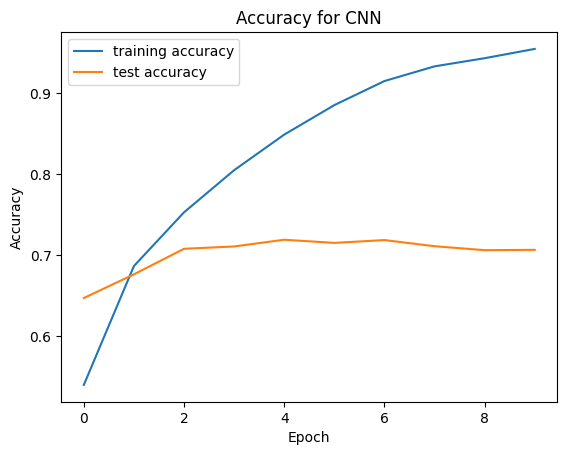

In [ ]:
plotAccuracies(history, 'CNN')

test_loss, test_acc = cnn_base.evaluate(testing_instances,  y_test, verbose=2)
print("Test loss is ", test_loss)
print("Test accuracy is ", test_acc)

### 3.5.2 Hyperparameter Tuning for the CNN

CREATE NEW MODEL EVERY TIME 

The first hyperparameter tested is the learning rate for the gradient descent. The model used for the remaining analysis on the CNN is the one with the max pooling since it has a better test accuracy

In [ ]:
def createCNN(kernel=3, stride=1):
  cnn = models.Sequential()

  cnn.add(layers.Conv2D(32, (kernel, kernel), strides=stride, activation='relu', input_shape=(32, 32, 3)))
  cnn.add(layers.MaxPooling2D((2, 2)))
  cnn.add(layers.Conv2D(64, (kernel, kernel), strides=stride, activation='relu'))
  cnn.add(layers.MaxPooling2D((2, 2)))
  cnn.add(layers.Flatten())
  cnn.add(layers.Dense(256, activation='relu'))
  cnn.add(layers.Dense(256, activation='relu'))
  cnn.add(layers.Dense(10, activation='softmax'))

  return cnn

In [ ]:
from tensorflow.keras import optimizers

default = 1e-3
x, test_accuracies = [], []

# With the results from the last plot,
# we can determine that 10 epochs leads to overfitting
epochs_before_overfitting = 10

for n in range(-4,7,2):
  learning_rate = default * 2**n
  x.append(learning_rate)
  cnn = createCNN()
  cnn.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  history = cnn.fit(training_instances, y_train_before, epochs=epochs_before_overfitting, 
                        validation_data=(testing_instances, y_test),
                        verbose=1)
  test_accuracies.append(np.max(history.history['val_accuracy']))



Epoch 1/10
1563/1563 [==============================] - 21s 6ms/step - loss: 1.6178 - accuracy: 0.4233 - val_loss: 1.4057 - val_accuracy: 0.4997
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3157 - accuracy: 0.5365 - val_loss: 1.2851 - val_accuracy: 0.5413
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1845 - accuracy: 0.5834 - val_loss: 1.1831 - val_accuracy: 0.5795
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0947 - accuracy: 0.6172 - val_loss: 1.0972 - val_accuracy: 0.6117
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0226 - accuracy: 0.6447 - val_loss: 1.0509 - val_accuracy: 0.6307
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9622 - accuracy: 0.6657 - val_loss: 1.0174 - val_accuracy: 0.6424
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9111 - accuracy: 0.6850 - val_loss: 0.9844 - val_accurac

The optimal learning rate is  0.001


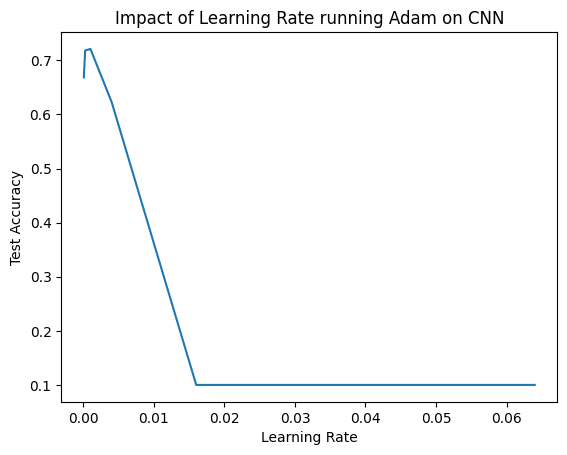

In [ ]:
print('The optimal learning rate is ', x[test_accuracies.index(max(test_accuracies))])
plt.plot(x, test_accuracies)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Impact of Learning Rate running Adam on CNN')
plt.show()

The second hyperparameter tested is the kernel size. Initially, the convolutional layers have a kernel size of (3,3). The kernel size are tested from 2 to 7 to see which size fit better the CNN architecture.

In [ ]:
x = range(1,7)
test_accuracies = []
# With the results from the last plot,
# we can determine that 10 epochs leads to overfitting
epochs_before_overfitting = 5

for n in x:
  cnn = createCNN(n)
  cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  history = cnn.fit(training_instances, y_train_before, epochs=epochs_before_overfitting, 
                        validation_data=(testing_instances, y_test),
                        verbose=1)
  test_loss, test_acc = cnn.evaluate(testing_instances,  y_test, verbose=2)
  test_accuracies.append(test_acc)



Epoch 1/5
1563/1563 [==============================] - 20s 6ms/step - loss: 1.4522 - accuracy: 0.4782 - val_loss: 1.3504 - val_accuracy: 0.5165
Epoch 2/5
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2073 - accuracy: 0.5680 - val_loss: 1.1878 - val_accuracy: 0.5732
Epoch 3/5
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0852 - accuracy: 0.6126 - val_loss: 1.1606 - val_accuracy: 0.5859
Epoch 4/5
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9836 - accuracy: 0.6503 - val_loss: 1.1748 - val_accuracy: 0.5945
Epoch 5/5
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8866 - accuracy: 0.6854 - val_loss: 1.1316 - val_accuracy: 0.6101
313/313 - 1s - loss: 1.1316 - accuracy: 0.6101 - 864ms/epoch - 3ms/step
Epoch 1/5
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2419 - accuracy: 0.5552 - val_loss: 0.9876 - val_accuracy: 0.6524
Epoch 2/5
1563/1563 [==============================] - 8s 5ms/step -

MAKE SCALE TO NOT HAVE .5s

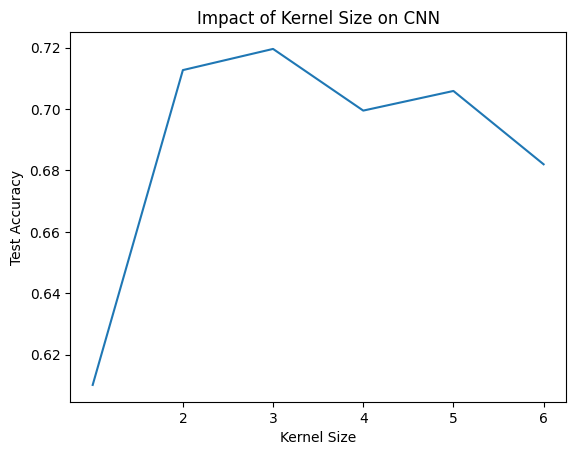

In [ ]:
plt.plot(x, test_accuracies)
plt.xlabel('Kernel Size')
plt.ylabel('Test Accuracy')
plt.title('Impact of Kernel Size on CNN')
plt.xticks(range(2,7))
plt.show()

The third hyperparameter tested is the stride size. Initially, the convolutional layers have a stride size of (1,1). The stride size are tested from 1 to 2 while keeping the kernel size constant to (3,3) to see which size fit better the CNN architecture.

In [ ]:
x = range(1,3)
test_accuracies = []
# With the results from the last plot,
# we can determine that 10 epochs leads to overfitting
epochs_before_overfitting = 5

for n in x:
  cnn = createCNN(3, n)
  cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  history = cnn.fit(training_instances, y_train_before, epochs=epochs_before_overfitting, 
                        validation_data=(testing_instances, y_test),
                        verbose=1)
  test_loss, test_acc = cnn.evaluate(testing_instances,  y_test, verbose=2)
  test_accuracies.append(test_acc)



Epoch 1/5
1563/1563 [==============================] - 11s 6ms/step - loss: 1.2986 - accuracy: 0.5370 - val_loss: 1.0218 - val_accuracy: 0.6426
Epoch 2/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.8939 - accuracy: 0.6854 - val_loss: 0.8984 - val_accuracy: 0.6895
Epoch 3/5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7176 - accuracy: 0.7496 - val_loss: 0.8555 - val_accuracy: 0.7061
Epoch 4/5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5777 - accuracy: 0.7968 - val_loss: 0.8663 - val_accuracy: 0.7143
Epoch 5/5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4546 - accuracy: 0.8391 - val_loss: 0.9401 - val_accuracy: 0.7118
313/313 - 1s - loss: 0.9401 - accuracy: 0.7118 - 747ms/epoch - 2ms/step
Epoch 1/5
1563/1563 [==============================] - 12s 6ms/step - loss: 1.6755 - accuracy: 0.3848 - val_loss: 1.4905 - val_accuracy: 0.4617
Epoch 2/5
1563/1563 [==============================] - 8s 5ms/step

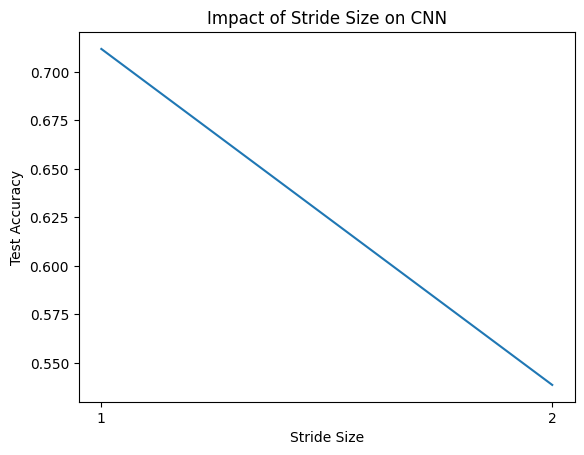

In [ ]:
plt.plot(x, test_accuracies)
plt.xlabel('Stride Size')
plt.ylabel('Test Accuracy')
plt.title('Impact of Stride Size on CNN')
plt.xticks(x)
plt.show()

## 3.6 - Pretrained Model

The section consists of a transfer learning exercice.The ResNet-50V2 architecture is loaded and all its layers and weights based on the ImageNet dataset are freezed (removing alsothe final classification layer). Then, fully connected layers are added and trained on the cifar10 dataset. 

### 3.6.1 Instantiating the pretrained model

In [ ]:
from keras.applications.resnet_v2 import ResNet50V2

# This code follows the documentation best practices from the Keras documentation:
# https://keras.io/guides/transfer_learning/ and a tutorial on the subject 
# https://medium.com/swlh/hands-on-the-cifar-10-dataset-with-transfer-learning-2e768fd6c318

# Input tensor of the custom model, used for upscaling and initiating the custom model
inputs = layers.Input(shape=(32, 32, 3))
# the model was trained with 224x224 images, need to upscale to improve performances
# the images are upscale from 32x32 to 160x160
upscale_tensor = layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                  224,
                                                                  224,
                                                                  method=tf.image.ResizeMethod.BILINEAR))(inputs)

# Initialize the base model
base_model = ResNet50V2(include_top=False, weights="imagenet", input_tensor=upscale_tensor, input_shape=(224,224,3))
base_model_with_classification_layer = ResNet50V2(include_top=True, weights="imagenet", input_shape=(224,224,3))
# Freeze the base model, weights will not change
base_model.trainable = False

102869336/102869336 [==============================] - 1s 0us/step


Printing the architecture of the complete ResNet-50V2

In [ ]:
print("ResNet-50v2 architecture with the top classification layer")
base_model_with_classification_layer.summary()

ResNet-50v2 architecture with the top classification layer
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                              

Printing the architecture of the ResNet-50V2 without the top layers for classification

In [ ]:
print("ResNet-50v2 architecture without the top classification layer")
base_model.summary()

ResNet-50v2 architecture without the top classification layer
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                           

### 3.6.2 Adding the custom layers

Adding 1 fully connected layer by adding a global average pooling layer, similar to the original architecture.

In [ ]:
from keras.models import Model
# tensor specifying the size of the input data
inputs = base_model.input
# Run the model in inference mode, return a tensor that will be the inputs of the custom layers
features = base_model(inputs, training=False)
# Flatten the output of the pretrained model
custom_inputs = layers.GlobalAveragePooling2D()(features)
# Ouput layer (classification)
outputs = layers.Dense(10, activation='softmax')(custom_inputs)

custom_model_1 = Model(inputs=inputs, outputs=outputs)

custom_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# need the min-max normalized data
training_instances_mm = x_train_normalized_before.reshape(x_train_normalized_before.shape[0], 32, 32, 3)
testing_instances_mm = x_test_normalized.reshape(x_test_normalized.shape[0], 32, 32, 3)

In [ ]:
epochs = 10

custom_model_1.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = custom_model_1.fit(training_instances_mm, y_train_before, epochs=epochs, 
                        validation_data=(testing_instances_mm, y_test),
                        verbose=1)


Epoch 1/10
1563/1563 [==============================] - 181s 113ms/step - loss: 0.3980 - accuracy: 0.8639 - val_loss: 0.4420 - val_accuracy: 0.8519
Epoch 2/10
1563/1563 [==============================] - 159s 102ms/step - loss: 0.3525 - accuracy: 0.8788 - val_loss: 0.4409 - val_accuracy: 0.8514
Epoch 3/10
1563/1563 [==============================] - 159s 102ms/step - loss: 0.3285 - accuracy: 0.8853 - val_loss: 0.4389 - val_accuracy: 0.8517
Epoch 4/10
1563/1563 [==============================] - 174s 112ms/step - loss: 0.3129 - accuracy: 0.8918 - val_loss: 0.4745 - val_accuracy: 0.8451
Epoch 5/10
1563/1563 [==============================] - 175s 112ms/step - loss: 0.2986 - accuracy: 0.8963 - val_loss: 0.4616 - val_accuracy: 0.8531
Epoch 6/10
1563/1563 [==============================] - 175s 112ms/step - loss: 0.2869 - accuracy: 0.8984 - val_loss: 0.4569 - val_accuracy: 0.8532
Epoch 7/10
1563/1563 [==============================] - 175s 112ms/step - loss: 0.2803 - accuracy: 0.9035 - val_

313/313 - 26s - loss: 0.4808 - accuracy: 0.8516 - 26s/epoch - 84ms/step
Test loss is  0.4808467626571655
Test accuracy is  0.8515999913215637


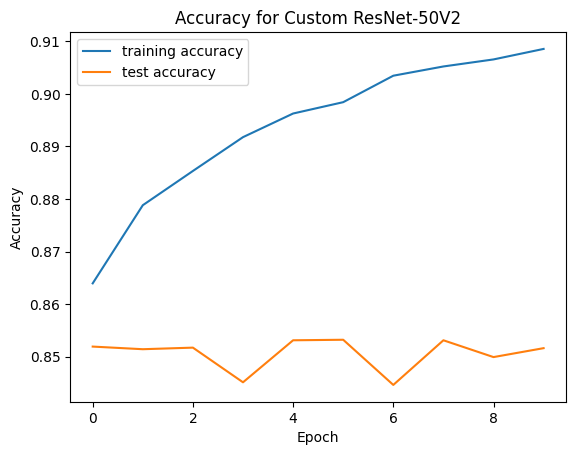

In [ ]:
plotAccuracies(history, 'Custom ResNet-50V2')

test_loss, test_acc = custom_model_1.evaluate(testing_instances_mm,  y_test, verbose=2)
print("Test loss is ", test_loss)
print("Test accuracy is ", test_acc)

Adding a second fully connected layer after the global average pooling layer with 2048 units.

In [ ]:
inputs = base_model.input
# Run the model in inference mode, return a tensor that will be the inputs of the custom layers
features = base_model(inputs, training=False)
# Flatten the output of the pretrained model
custom_inputs = layers.GlobalAveragePooling2D()(features)
# Add the fully connected layers 
hidden_1 = layers.Dense(2048, activation='relu')(custom_inputs)
# Ouput layer (classification)
outputs = layers.Dense(10, activation='softmax')(hidden_1)

custom_model_2 = Model(inputs=inputs, outputs=outputs)

custom_model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                                 
Total params: 27,781,642
Trainable params: 4,216,842
Non-trainable params: 23,564,800
_______________________________________

In [ ]:
custom_model_2.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = custom_model_2.fit(training_instances_mm, y_train_before, epochs=epochs, 
                        validation_data=(testing_instances_mm, y_test),
                        verbose=1)



Epoch 1/10
1563/1563 [==============================] - 179s 112ms/step - loss: 0.5240 - accuracy: 0.8218 - val_loss: 0.4630 - val_accuracy: 0.8396
Epoch 2/10
1563/1563 [==============================] - 174s 111ms/step - loss: 0.3639 - accuracy: 0.8741 - val_loss: 0.4224 - val_accuracy: 0.8571
Epoch 3/10
1563/1563 [==============================] - 176s 112ms/step - loss: 0.2825 - accuracy: 0.9002 - val_loss: 0.4399 - val_accuracy: 0.8611
Epoch 4/10
1563/1563 [==============================] - 161s 103ms/step - loss: 0.2066 - accuracy: 0.9271 - val_loss: 0.4672 - val_accuracy: 0.8634
Epoch 5/10
1563/1563 [==============================] - 176s 112ms/step - loss: 0.1495 - accuracy: 0.9460 - val_loss: 0.5311 - val_accuracy: 0.8568
Epoch 6/10
1563/1563 [==============================] - 159s 102ms/step - loss: 0.1082 - accuracy: 0.9619 - val_loss: 0.6055 - val_accuracy: 0.8539
Epoch 7/10
1563/1563 [==============================] - 161s 103ms/step - loss: 0.0878 - accuracy: 0.9696 - val_

313/313 - 26s - loss: 0.8604 - accuracy: 0.8618 - 26s/epoch - 82ms/step
Test loss is  0.8603590130805969
Test accuracy is  0.8618000149726868


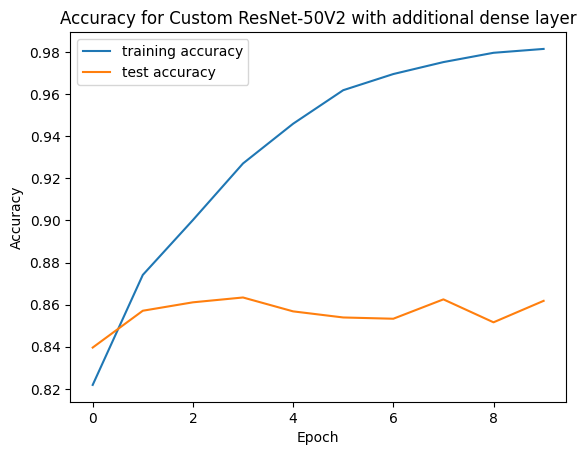

In [ ]:
plotAccuracies(history, 'Custom ResNet-50V2 with additional dense layer')

test_loss, test_acc = custom_model_2.evaluate(testing_instances_mm,  y_test, verbose=2)
print("Test loss is ", test_loss)
print("Test accuracy is ", test_acc)

Adding a third fully connected with 2048 units.

In [ ]:
inputs = base_model.input
# Run the model in inference mode, return a tensor that will be the inputs of the custom layers
features = base_model(inputs, training=False)
# Flatten the output of the pretrained model
custom_inputs = layers.GlobalAveragePooling2D()(features)
# Add the fully connected layers 
hidden_1 = layers.Dense(2048, activation='relu')(custom_inputs)
hidden_2 = layers.Dense(2048, activation='relu')(hidden_1)
# Ouput layer (classification)
outputs = layers.Dense(10, activation='softmax')(hidden_2)

custom_model_3 = Model(inputs=inputs, outputs=outputs)

custom_model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                           

In [ ]:
custom_model_3.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = custom_model_3.fit(training_instances_mm, y_train_before, epochs=epochs, 
                        validation_data=(testing_instances_mm, y_test),
                        verbose=1)



Epoch 1/10
1563/1563 [==============================] - 183s 114ms/step - loss: 0.5466 - accuracy: 0.8167 - val_loss: 0.4398 - val_accuracy: 0.8467
Epoch 2/10
1563/1563 [==============================] - 178s 114ms/step - loss: 0.3806 - accuracy: 0.8685 - val_loss: 0.4559 - val_accuracy: 0.8485
Epoch 3/10
1563/1563 [==============================] - 177s 113ms/step - loss: 0.3057 - accuracy: 0.8923 - val_loss: 0.4904 - val_accuracy: 0.8467
Epoch 4/10
1563/1563 [==============================] - 175s 112ms/step - loss: 0.2465 - accuracy: 0.9134 - val_loss: 0.4676 - val_accuracy: 0.8548
Epoch 5/10
1563/1563 [==============================] - 161s 103ms/step - loss: 0.1908 - accuracy: 0.9320 - val_loss: 0.4944 - val_accuracy: 0.8624
Epoch 6/10
1563/1563 [==============================] - 162s 104ms/step - loss: 0.1542 - accuracy: 0.9460 - val_loss: 0.5743 - val_accuracy: 0.8585
Epoch 7/10
1563/1563 [==============================] - 178s 114ms/step - loss: 0.1244 - accuracy: 0.9560 - val_

313/313 - 26s - loss: 0.8795 - accuracy: 0.8571 - 26s/epoch - 82ms/step
Test loss is  0.8795220851898193
Test accuracy is  0.8571000099182129


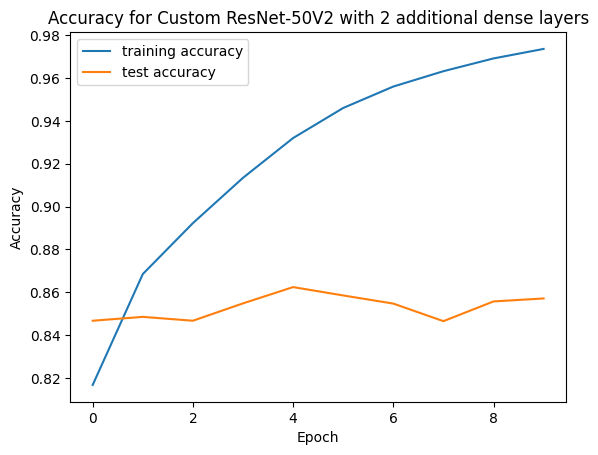

In [ ]:
plotAccuracies(history, 'Custom ResNet-50V2 with 2 additional dense layers')

test_loss, test_acc = custom_model_3.evaluate(testing_instances_mm,  y_test, verbose=2)
print("Test loss is ", test_loss)
print("Test accuracy is ", test_acc)